## Big Data in Finance Individual Assignment

### Stock Predictive Model

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model, svm, gaussian_process, ensemble, decomposition, pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy import stats

%matplotlib inline

# Display 4 decimal point for floats
pd.options.display.float_format = '{:,.4f}'.format

#### Read in Data

In [2]:
# Read in the Data
stockReturns = pd.read_excel('Data.xlsx', skiprows = 4, parse_cols = 'B:AY', index_col = 0)
stockReturns.columns = [x.strip() for x in stockReturns.columns] # Strip off whitespaces
industryNames = stockReturns.columns.values
noInd = len(industryNames)

#### Contemporaneous Relationships - Correlation between Industries

##### Most Correlated Industries

In [249]:
# Correlation Matrix
corrDF = stockReturns.corr()

# Set diagonal elements to NAN since they are not useful info
for i in range(corrDF.shape[0]):
    corrDF.iloc[i, i] = np.nan

# Find the most correlated industries (in absolute correlation values), and display them
mostCorr = corrDF.abs().idxmax()
corrValues = []
for i in range(mostCorr.shape[0]):
    corrValues.append(corrDF.loc[mostCorr.index[i], mostCorr.values[i]])
mostCorr = mostCorr.to_frame(name = 'Industry')
mostCorr['Corr'] = corrValues
mostCorr

Industry   Corr
Agric    Chems 0.5878
Food      Beer 0.7777
Soda      Beer 0.8153
Beer      Soda 0.8153
Smoke     Beer 0.7479
Toys     BusSv 0.6357
Fun      BusSv 0.6878
Books    BusSv 0.8234
Hshld    Paper 0.7966
Clths    Rtail 0.7399
Hlth     MedEq 0.6888
MedEq    LabEq 0.7905
Drugs    LabEq 0.7733
Chems     Mach 0.8296
Rubbr    BusSv 0.8668
Txtls    BusSv 0.7247
BldMt    Cnstr 0.8685
Cnstr    BldMt 0.8685
Steel     Mach 0.8155
FabPr     Mach 0.6912
Mach     ElcEq 0.8979
ElcEq     Mach 0.8979
Autos     Mach 0.7984
Aero     Paper 0.8003
Ships     Mach 0.7624
Guns      Aero 0.6687
Gold     Mines 0.3699
Mines    Steel 0.8069
Coal       Oil 0.5960
Oil       Mach 0.7704
Util      Food 0.6413
Telcm    BusSv 0.7974
PerSv    BusSv 0.8309
BusSv    LabEq 0.8917
Hardw    BusSv 0.8047
Softw    BusSv 0.8472
Chips    Hardw 0.7737
LabEq    BusSv 0.8917
Paper    BusSv 0.8483
Boxes    Paper 0.7962
Trans    BusSv 0.8091
Whlsl    BusSv 0.8623
Rtail    Meals 0.8003
Meals    Rtail 0.8003
Banks      Fin 0.9391
Insur      Fin 0.8878
RlEst    BusSv 0.8370
Fin      Banks 0.9391
Other      Fin 0.8340

##### Least Correlated Industries

In [250]:
# Find the least correlated industries (in absolute correlation values), and display them
leastCorr = corrDF.abs().idxmin()
corrValues = []
for i in range(leastCorr.shape[0]):
    corrValues.append(corrDF.loc[leastCorr.index[i], leastCorr.values[i]])
leastCorr = leastCorr.to_frame(name = 'Industry')
leastCorr['Corr'] = corrValues
leastCorr


Industry    Corr
Agric     Gold  0.0944
Food      Gold  0.1681
Soda      Coal  0.0933
Beer      Gold  0.1262
Smoke     Coal  0.1041
Toys      Gold  0.1358
Fun       Gold  0.0903
Books     Gold  0.1058
Hshld     Gold  0.1744
Clths     Gold -0.0158
Hlth      Gold  0.0217
MedEq     Gold  0.0713
Drugs     Gold  0.0811
Chems     Gold  0.2008
Rubbr     Gold  0.0802
Txtls     Gold  0.0248
BldMt     Gold  0.0978
Cnstr     Gold  0.1254
Steel    Smoke  0.2368
FabPr    Smoke  0.1770
Mach      Gold  0.1896
ElcEq     Gold  0.1736
Autos     Gold  0.0898
Aero      Gold  0.1021
Ships     Gold  0.1514
Guns      Gold  0.0458
Gold     Insur  0.0112
Mines    Smoke  0.2365
Coal      Soda  0.0933
Oil      Smoke  0.2667
Util     Banks  0.2818
Telcm     Gold  0.1822
PerSv     Gold  0.0751
BusSv     Gold  0.0818
Hardw     Gold  0.1181
Softw     Gold  0.0597
Chips     Gold  0.0867
LabEq     Gold  0.1061
Paper     Gold  0.1556
Boxes     Gold  0.1672
Trans     Gold  0.0647
Whlsl     Gold  0.1309
Rtail     Gold  0.0284
Meals     Gold  0.0114
Banks     Gold -0.0461
Insur     Gold  0.0112
RlEst     Gold  0.0665
Fin       Gold  0.0316
Other     Gold  0.0780

#### Rolling Window Method

In [6]:
# Use Rolling Window method to train predictors and compute the OOS MSE for the method
def fitAndPredictOOS(stockReturns, model, windowSize = 80, lag = 3, lasso = False):
    #print("Lag = ", lag)
    xMat = stockReturns.as_matrix()
    modelMSEList = []
    selectedVarList = []
    for industry in stockReturns.columns.values:
        #print("Industry = ", industry)
        #starttime = datetime.now()
        yMat = stockReturns[industry].as_matrix()
        modelMSE = []
        selectedVar = np.zeros(lag * stockReturns.shape[1], dtype = np.int) # Store selected variables by LASSO
        for yIdx in range(lag, stockReturns.shape[0] - windowSize):            
            #print("yIdx = ", yIdx)
            xIdx = yIdx - 1
            Y = yMat[yIdx:(yIdx + windowSize)]
            X = xMat[xIdx:(xIdx + windowSize)]
            for i in range(1, lag): # Add lagged components to the X matrix
                xIdxLag = xIdx - i
                X = np.concatenate((X, xMat[xIdxLag:(xIdxLag + windowSize)]), axis = 1)
            if model != 'HistMean':
                model.fit(X, Y)
            
            if (lasso): # Increment the count of selected variables
                idxAttrToUse = list(np.where(model.coef_ != 0)[0])
                selectedVar[idxAttrToUse] += 1
            
            actY = yMat[yIdx + windowSize]
            xPred = xMat[xIdx + windowSize]
            for i in range(1, lag): # Add lagged components to the xPred matrix
                xPred = np.concatenate((xPred, xMat[xIdx + windowSize - i]))
            if model != 'HistMean':
                modelPred = model.predict(np.array([xPred]))
            else: # Historical Mean Method
                modelPred = [np.mean(Y)]
            modelMSE.append((modelPred[0] - actY)**2)
        
        modelMSEList.append(np.array(modelMSE))
        selectedVarList.append(selectedVar)
        #endtime = datetime.now()
        #print("Start Time: ", starttime)
        #print("End Time: ", endtime)
    
    if (lasso):
        return np.array(modelMSEList).transpose(), np.array(selectedVarList)
    else:
        return np.array(modelMSEList).transpose()

In [7]:
# Window Size
w = 80
# Historical Mean benchmark
histMeanMSE = fitAndPredictOOS(stockReturns, model = 'HistMean', windowSize = w, lag = 1)
# OLS benchmark (1 day lag)
olsMSE = fitAndPredictOOS(stockReturns, model = linear_model.LinearRegression(),  windowSize = w, lag = 1)

#### Train the 5 Types of Predictive Models with Different Sets of Lags

In [9]:
# LASSO Model with different day lags - tol adjusted for faster convergence
lassoMSE1, lassoVars1 = fitAndPredictOOS(stockReturns, 
                                         model = linear_model.LassoCV(cv = TimeSeriesSplit(n_splits = 10), 
                                                                      normalize = True, tol = 0.01, 
                                                                      max_iter = 100000), 
                                         windowSize = w, 
                                         lag = 1, 
                                         lasso = True)
lassoMSE2, lassoVars2 = fitAndPredictOOS(stockReturns, 
                                         model = linear_model.LassoCV(cv = TimeSeriesSplit(n_splits = 10), 
                                                                      normalize = True, tol = 0.01, 
                                                                      max_iter = 100000), 
                                         windowSize = w, 
                                         lag = 2, 
                                         lasso = True)
lassoMSE3, lassoVars3 = fitAndPredictOOS(stockReturns, 
                                         model = linear_model.LassoCV(cv = TimeSeriesSplit(n_splits = 10), 
                                                                      normalize = True, tol = 0.01, 
                                                                      max_iter = 100000), 
                                         windowSize = w, 
                                         lag = 3, 
                                         lasso = True)
lassoMSE4, lassoVars4 = fitAndPredictOOS(stockReturns, 
                                         model = linear_model.LassoCV(cv = TimeSeriesSplit(n_splits = 10), 
                                                                      normalize = True, tol = 0.01, 
                                                                      max_iter = 100000), 
                                         windowSize = w, 
                                         lag = 4, 
                                         lasso = True)
lassoMSE5, lassoVars5 = fitAndPredictOOS(stockReturns, 
                                         model = linear_model.LassoCV(cv = TimeSeriesSplit(n_splits = 10), 
                                                                      normalize = True, tol = 0.01, 
                                                                      max_iter = 100000), 
                                         windowSize = w, 
                                         lag = 5, 
                                         lasso = True)

# Save results to CSV Files
pd.DataFrame(lassoMSE1).to_csv('lassoMSE1.csv')
pd.DataFrame(lassoMSE2).to_csv('lassoMSE2.csv')
pd.DataFrame(lassoMSE3).to_csv('lassoMSE3.csv')
pd.DataFrame(lassoMSE4).to_csv('lassoMSE4.csv')
pd.DataFrame(lassoMSE5).to_csv('lassoMSE5.csv')

pd.DataFrame(lassoVars1).to_csv('lassoVars1.csv')
pd.DataFrame(lassoVars2).to_csv('lassoVars2.csv')
pd.DataFrame(lassoVars3).to_csv('lassoVars3.csv')
pd.DataFrame(lassoVars4).to_csv('lassoVars4.csv')
pd.DataFrame(lassoVars5).to_csv('lassoVars5.csv')

# ElasticNet Model with different day lags - Lower Number of n_alphas to speed up the fitting
enMSE1 = fitAndPredictOOS(stockReturns, 
                          model = linear_model.ElasticNetCV(l1_ratio = [.3, .9, 1], 
                                                            normalize = True, 
                                                            cv = TimeSeriesSplit(n_splits = 10), 
                                                            n_alphas = 25, 
                                                            tol = 0.01, 
                                                            max_iter = 100000), 
                          windowSize = w, 
                          lag = 1)
enMSE2 = fitAndPredictOOS(stockReturns, 
                          model = linear_model.ElasticNetCV(l1_ratio = [.3, .9, 1], 
                                                            normalize = True, 
                                                            cv = TimeSeriesSplit(n_splits = 10), 
                                                            n_alphas = 25, 
                                                            tol = 0.01, 
                                                            max_iter = 100000), 
                          windowSize = w, 
                          lag = 2)
enMSE3 = fitAndPredictOOS(stockReturns, 
                          model = linear_model.ElasticNetCV(l1_ratio = [.3, .9, 1], 
                                                            normalize = True, 
                                                            cv = TimeSeriesSplit(n_splits = 10), 
                                                            n_alphas = 25, 
                                                            tol = 0.01, 
                                                            max_iter = 100000), 
                          windowSize = w, 
                          lag = 3)
enMSE4 = fitAndPredictOOS(stockReturns, 
                          model = linear_model.ElasticNetCV(l1_ratio = [.3, .9, 1], 
                                                            normalize = True, 
                                                            cv = TimeSeriesSplit(n_splits = 10), 
                                                            n_alphas = 25, 
                                                            tol = 0.01, 
                                                            max_iter = 100000), 
                          windowSize = w, 
                          lag = 4)
enMSE5 = fitAndPredictOOS(stockReturns, 
                          model = linear_model.ElasticNetCV(l1_ratio = [.3, .9, 1], 
                                                            normalize = True, 
                                                            cv = TimeSeriesSplit(n_splits = 10), 
                                                            n_alphas = 25, 
                                                            tol = 0.01, 
                                                            max_iter = 100000), 
                          windowSize = w, 
                          lag = 5)

# Save results to CSV Files
pd.DataFrame(enMSE1).to_csv('enMSE1.csv')
pd.DataFrame(enMSE2).to_csv('enMSE2.csv')
pd.DataFrame(enMSE3).to_csv('enMSE3.csv')
pd.DataFrame(enMSE4).to_csv('enMSE4.csv')
pd.DataFrame(enMSE5).to_csv('enMSE5.csv')

# RandomForest Regression with different day lags - min_samples_leaf is cross-validated from 3 values
param_grid = {"min_samples_leaf": [2, 6, 10]}
rfMSE1 = fitAndPredictOOS(stockReturns, model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), 
                                                             param_grid = param_grid, 
                                                             cv = TimeSeriesSplit(n_splits = 10)), 
                          windowSize = w, lag = 1)
rfMSE2 = fitAndPredictOOS(stockReturns, model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), 
                                                             param_grid = param_grid, 
                                                             cv = TimeSeriesSplit(n_splits = 10)), 
                          windowSize = w, lag = 2)
rfMSE3 = fitAndPredictOOS(stockReturns, model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), 
                                                             param_grid = param_grid, 
                                                             cv = TimeSeriesSplit(n_splits = 10)), 
                          windowSize = w, lag = 3)
rfMSE4 = fitAndPredictOOS(stockReturns, model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), 
                                                             param_grid = param_grid, 
                                                             cv = TimeSeriesSplit(n_splits = 10)), 
                          windowSize = w, lag = 4)
rfMSE5 = fitAndPredictOOS(stockReturns, model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), 
                                                             param_grid = param_grid, 
                                                             cv = TimeSeriesSplit(n_splits = 10)), 
                          windowSize = w, lag = 5)

# Save results to CSV Files
pd.DataFrame(rfMSE1).to_csv('rfMSE1.csv')
pd.DataFrame(rfMSE2).to_csv('rfMSE2.csv')
pd.DataFrame(rfMSE3).to_csv('rfMSE3.csv')
pd.DataFrame(rfMSE4).to_csv('rfMSE4.csv')
pd.DataFrame(rfMSE5).to_csv('rfMSE5.csv')

# GaussianProcess Regression with different day lags - alpha (noise level) is cross-validated from uniform distribution
param_dist = {"alpha": stats.uniform(loc = 1e-10, scale = 1e-1)}
gprMSE1 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(gaussian_process.GaussianProcessRegressor(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 1)
gprMSE2 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(gaussian_process.GaussianProcessRegressor(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 2)
gprMSE3 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(gaussian_process.GaussianProcessRegressor(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 3)
gprMSE4 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(gaussian_process.GaussianProcessRegressor(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 4)
gprMSE5 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(gaussian_process.GaussianProcessRegressor(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 5)

# Save results to CSV Files
pd.DataFrame(gprMSE1).to_csv('gprMSE1.csv')
pd.DataFrame(gprMSE2).to_csv('gprMSE2.csv')
pd.DataFrame(gprMSE3).to_csv('gprMSE3.csv')
pd.DataFrame(gprMSE4).to_csv('gprMSE4.csv')
pd.DataFrame(gprMSE5).to_csv('gprMSE5.csv')

# SupportVector Regression with different day lags - C & epsilon are cross-validated from uniform distributions
param_dist = {"C": stats.uniform(loc = 0.1, scale = 1.9), 
              "epsilon": stats.uniform(loc = 0.1, scale = 0.4)}
svrMSE1 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(svm.SVR(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 1)
svrMSE2 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(svm.SVR(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 2)
svrMSE3 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(svm.SVR(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 3)
svrMSE4 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(svm.SVR(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 4)
svrMSE5 = fitAndPredictOOS(stockReturns, 
                           model = RandomizedSearchCV(svm.SVR(), 
                                                      param_distributions = param_dist, 
                                                      n_iter = 10, 
                                                      cv = TimeSeriesSplit(n_splits = 10)), 
                           windowSize = w, lag = 5)

# Save results to CSV Files
pd.DataFrame(svrMSE1).to_csv('svrMSE1.csv')
pd.DataFrame(svrMSE2).to_csv('svrMSE2.csv')
pd.DataFrame(svrMSE3).to_csv('svrMSE3.csv')
pd.DataFrame(svrMSE4).to_csv('svrMSE4.csv')
pd.DataFrame(svrMSE5).to_csv('svrMSE5.csv')

#### Function to compute the Cumulative RMSE Difference & R-Square OOS

In [8]:
# Calculate the cumulative RMSE Difference and R^2 OOS
def compCumRMSEAndRSqr(benchmarkMSE, modelMSE, lenDates):
    benchmarkRMSE = np.sqrt(benchmarkMSE)
    modelRMSE = np.sqrt(modelMSE)
    # Benchmark model is always a 1-day Lag model, while predictive model can involve n-day lag
    diffLength = benchmarkRMSE.shape[0] - modelRMSE.shape[0]
    # Only start subtracting when predictive model (n-day lag) starts to have Out-Of-Sample predictions
    diffRMSE = benchmarkRMSE[diffLength: , :] - modelRMSE
    cumDiff = diffRMSE.cumsum(axis = 0)
    
    # Pad with zeroes in periods where there is no predictions (useful for plotting purposes)
    padZeroes = lenDates - cumDiff.shape[0]
    cumDiff = np.vstack((np.zeros((padZeroes, cumDiff.shape[1])), cumDiff))
    
    RsqrOOS = 1 - (np.sum(modelMSE, axis = 0) / np.sum(benchmarkMSE[diffLength: , :], axis = 0))
    
    return cumDiff, RsqrOOS

#### Functions to Plot the Cumulative RMSE Difference

In [58]:
# Plot the cumulative RMSE for all industries in a single plot
def plotCRMSEAllInd(stockReturns, cumDiff):
    
    plt.figure(figsize = (10, 6))
    datesList = [datetime.strptime(str(date), '%Y%m%d').date() for date in stockReturns.index.values]    
    
    for i in range(cumDiff.shape[1]):
        plt.plot(datesList, cumDiff[:, i], label = stockReturns.columns.values[i])
    #plt.legend(loc = 'upper left')
    plt.axhline(0, color = 'grey', ls = 'dashed')
    #plt.title("Cumulative RMSE Difference vs Day")
    plt.xlabel("Day")
    plt.ylabel("Cumulative RMSE Difference")
    plt.show()
    plt.close()    

In [53]:
# Plot the cumulative RMSE in multiple plots, each plot has multiple lags models for a single industry
def plotCRMSEAllLags(stockReturns, cumDiffList):
    
    plt.figure(figsize = (18, 36))
    datesList = [datetime.strptime(str(date), '%Y%m%d').date() for date in stockReturns.index.values]
    pIdx = 1
    for i in range(stockReturns.shape[1]):
        j = 1
        plt.subplot(10, 5, pIdx)
        for cumDiff in cumDiffList:
            plt.plot(datesList, cumDiff[:, i], label = str(j) + ' Day Lag')
            j += 1
        
        plt.axhline(0, color = 'grey', ls = 'dashed')
        pIdx += 1
        #plt.yticks(np.arange(-5, 5+1, 5))
        plt.tick_params(bottom = 'off', labelbottom='off')
        plt.title(stockReturns.columns.values[i])
        #plt.legend(loc = 'upper left')
    plt.subplot(10, 5, pIdx)
    j = 1
    for cumDiff in cumDiffList:
        plt.plot(datesList, np.zeros(len(datesList)), label = str(j) + ' Day Lag' )
        j += 1
    plt.axhline(0, color = 'grey', ls = 'dashed')
    plt.tick_params(left = 'off', labelleft = 'off', bottom = 'off', labelbottom='off')
    plt.legend(loc = 'upper left')
    #plt.xlabel("Day")
    #plt.ylabel("Cumulative RMSE Difference")
    plt.show()
    plt.close()

#### LASSO (1 Day Lag) vs OLS

Average R-Square OOS across all industries is 0.6713


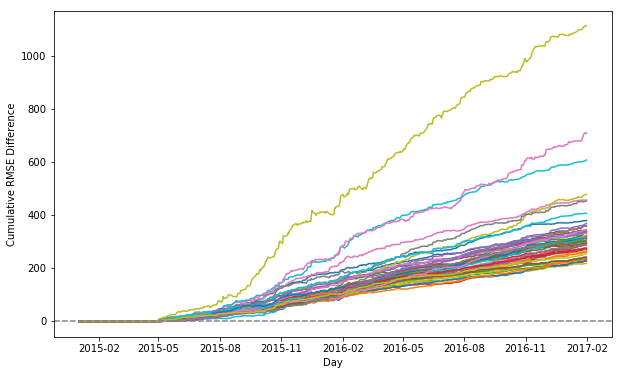

In [94]:
lassoMSE1 = pd.read_csv('lassoMSE1.csv', index_col = 0, header = 0).as_matrix()

LASSOvsOLScrmse1, LASSOvsOLSrsqr1 = compCumRMSEAndRSqr(olsMSE, lassoMSE1, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsOLSrsqr1))

plotCRMSEAllInd(stockReturns, LASSOvsOLScrmse1)

#### LASSO (2 Days Lag) vs OLS

Average R-Square OOS across all industries is 0.6726


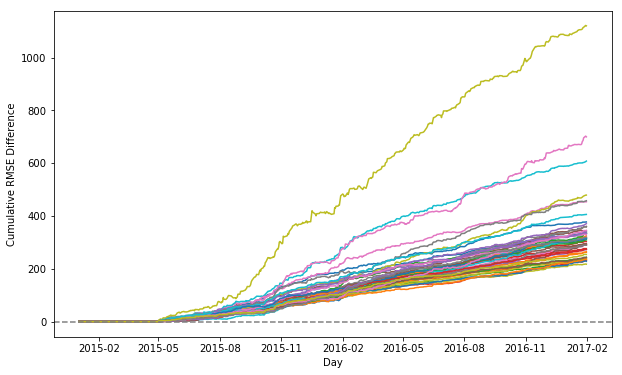

In [62]:
lassoMSE2 = pd.read_csv('lassoMSE2.csv', index_col = 0, header = 0).as_matrix()
LASSOvsOLScrmse2, LASSOvsOLSrsqr2 = compCumRMSEAndRSqr(olsMSE, lassoMSE2, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsOLSrsqr2))

plotCRMSEAllInd(stockReturns, LASSOvsOLScrmse2)

#### LASSO (3 Days Lag) vs OLS

In [251]:
lassoMSE3 = pd.read_csv('lassoMSE3.csv', index_col = 0, header = 0).as_matrix()
LASSOvsOLScrmse3, LASSOvsOLSrsqr3 = compCumRMSEAndRSqr(olsMSE, lassoMSE3, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsOLSrsqr3))

# The CRMSE Graph looks similar hence we shall not replot
#plotCRMSEAllInd(stockReturns, LASSOvsOLScrmse3)

Average R-Square OOS across all industries is 0.6720


#### LASSO (4 Days Lag) vs OLS

In [252]:
lassoMSE4 = pd.read_csv('lassoMSE4.csv', index_col = 0, header = 0).as_matrix()
LASSOvsOLScrmse4, LASSOvsOLSrsqr4 = compCumRMSEAndRSqr(olsMSE, lassoMSE4, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsOLSrsqr4))

# The CRMSE Graph looks similar hence we shall not replot
#plotCRMSEAllInd(stockReturns, LASSOvsOLScrmse4)

Average R-Square OOS across all industries is 0.6715


#### LASSO (5 Days Lag) vs OLS

In [253]:
lassoMSE5 = pd.read_csv('lassoMSE5.csv', index_col = 0, header = 0).as_matrix()
LASSOvsOLScrmse5, LASSOvsOLSrsqr5 = compCumRMSEAndRSqr(olsMSE, lassoMSE5, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsOLSrsqr5))

# The CRMSE Graph looks similar hence we shall not replot
#plotCRMSEAllInd(stockReturns, LASSOvsOLScrmse5)

Average R-Square OOS across all industries is 0.6722


#### LASSO (All 5 Days Lag) vs OLS - Breakdown by Industry

We can see from the below graphs that the LASSO models with different day lags have very slight difference. To examine this difference, we will use the R-Square OOS to compare in later sections.

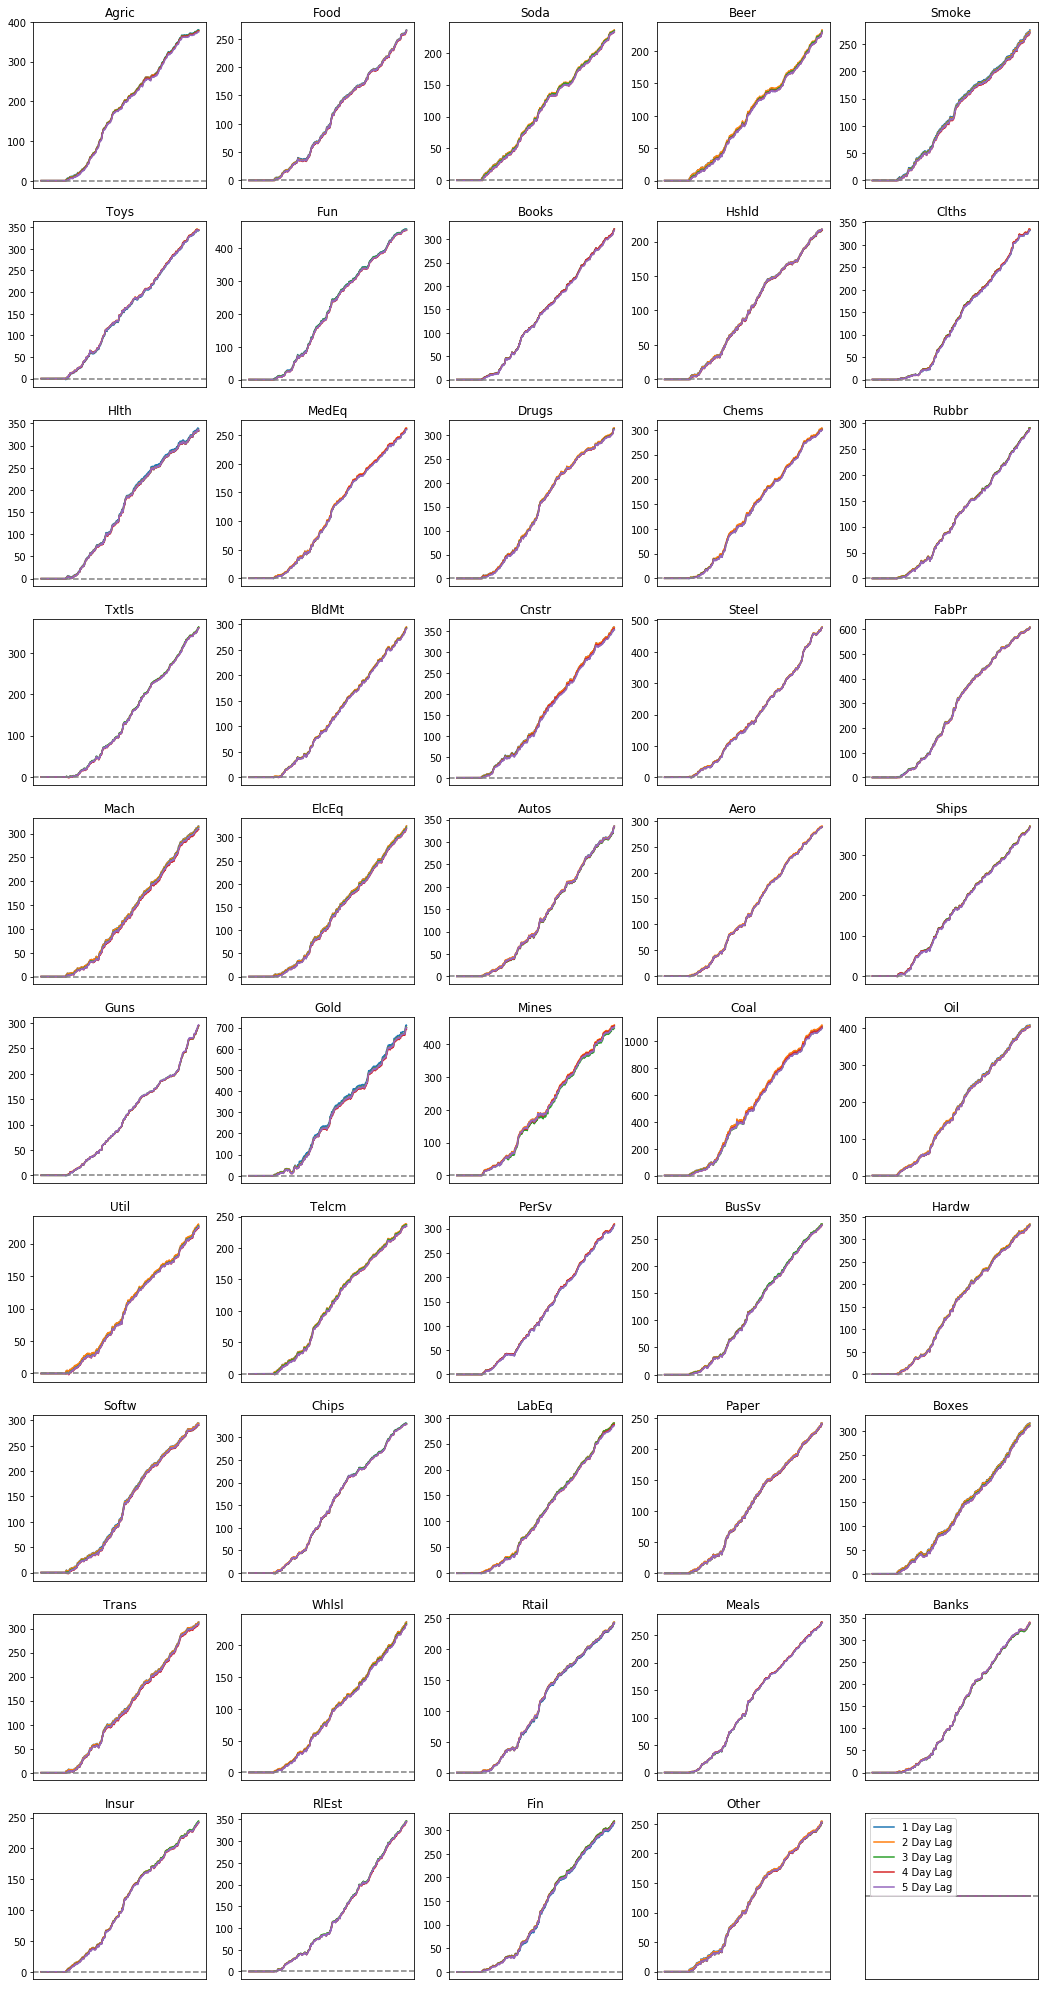

In [54]:
plotCRMSEAllLags(stockReturns, [LASSOvsOLScrmse1, LASSOvsOLScrmse2, LASSOvsOLScrmse3, LASSOvsOLScrmse4, LASSOvsOLScrmse5])

#### LASSO (1 Day Lag) vs Historical Mean

Average R-Square OOS across all industries is -0.0071


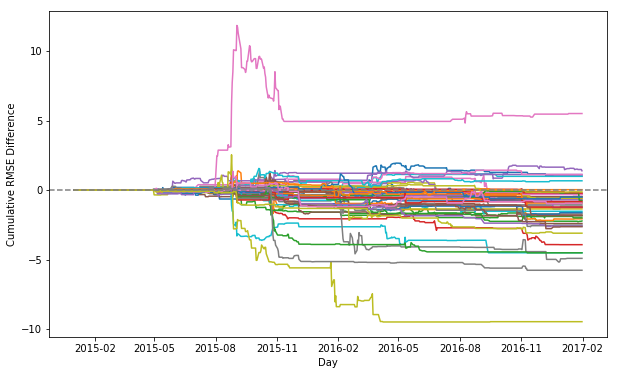

In [71]:
LASSOvsHistMeancrmse1, LASSOvsHistMeanrsqr1 = compCumRMSEAndRSqr(histMeanMSE, lassoMSE1, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsHistMeanrsqr1))

plotCRMSEAllInd(stockReturns, LASSOvsHistMeancrmse1)

#### LASSO (2 Days Lag) vs Historical Mean

Average R-Square OOS across all industries is -0.0051


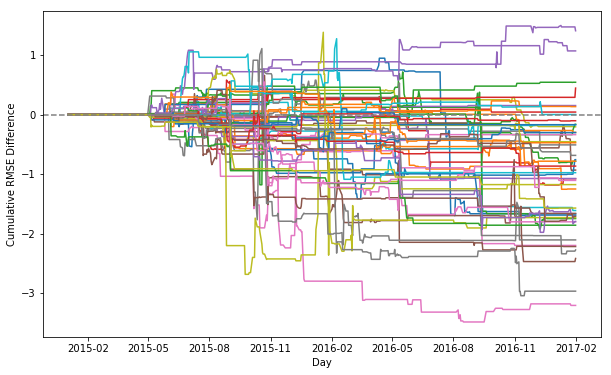

In [234]:
LASSOvsHistMeancrmse2, LASSOvsHistMeanrsqr2 = compCumRMSEAndRSqr(histMeanMSE, lassoMSE2, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsHistMeanrsqr2))

plotCRMSEAllInd(stockReturns, LASSOvsHistMeancrmse2)

#### LASSO (3 Days Lag) vs Historical Mean

Average R-Square OOS across all industries is -0.0055


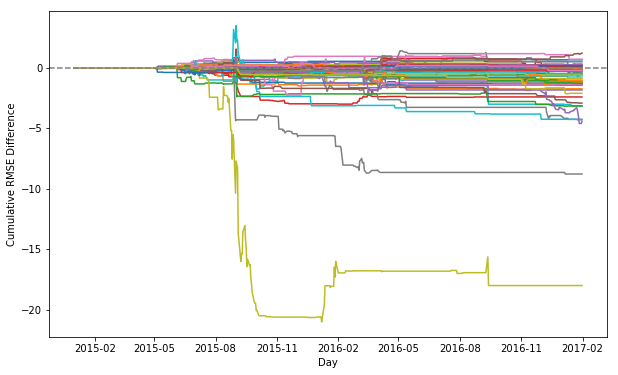

In [73]:
LASSOvsHistMeancrmse3, LASSOvsHistMeanrsqr3 = compCumRMSEAndRSqr(histMeanMSE, lassoMSE3, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsHistMeanrsqr3))

plotCRMSEAllInd(stockReturns, LASSOvsHistMeancrmse3)

#### LASSO (4 Days Lag) vs Historical Mean

Average R-Square OOS across all industries is -0.0066


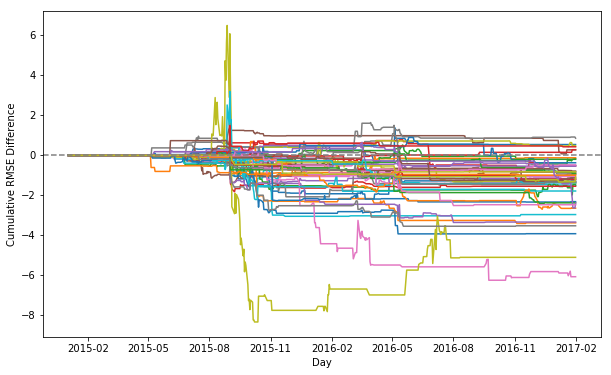

In [74]:
LASSOvsHistMeancrmse4, LASSOvsHistMeanrsqr4 = compCumRMSEAndRSqr(histMeanMSE, lassoMSE4, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsHistMeanrsqr4))

plotCRMSEAllInd(stockReturns, LASSOvsHistMeancrmse4)

#### LASSO (5 Days Lag) vs Historical Mean

Average R-Square OOS across all industries is -0.0060


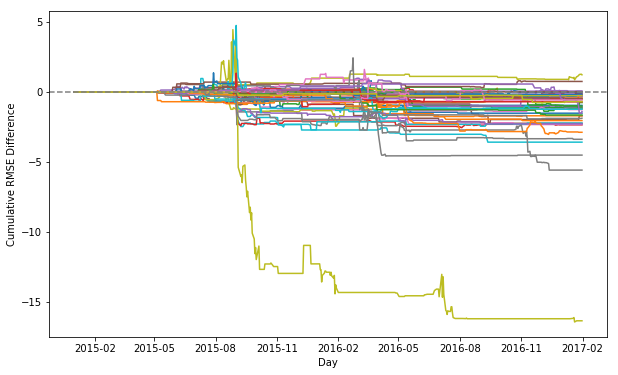

In [75]:
LASSOvsHistMeancrmse5, LASSOvsHistMeanrsqr5 = compCumRMSEAndRSqr(histMeanMSE, lassoMSE5, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(LASSOvsHistMeanrsqr5))

plotCRMSEAllInd(stockReturns, LASSOvsHistMeancrmse5)

#### LASSO (All 5 Days Lag) vs Historical Mean - Breakdown by Industry

Due to the smaller scale on the y-axis, we are able to observe the minor differences between the models of different lags. We can see that in each industry, the lag structures are different.

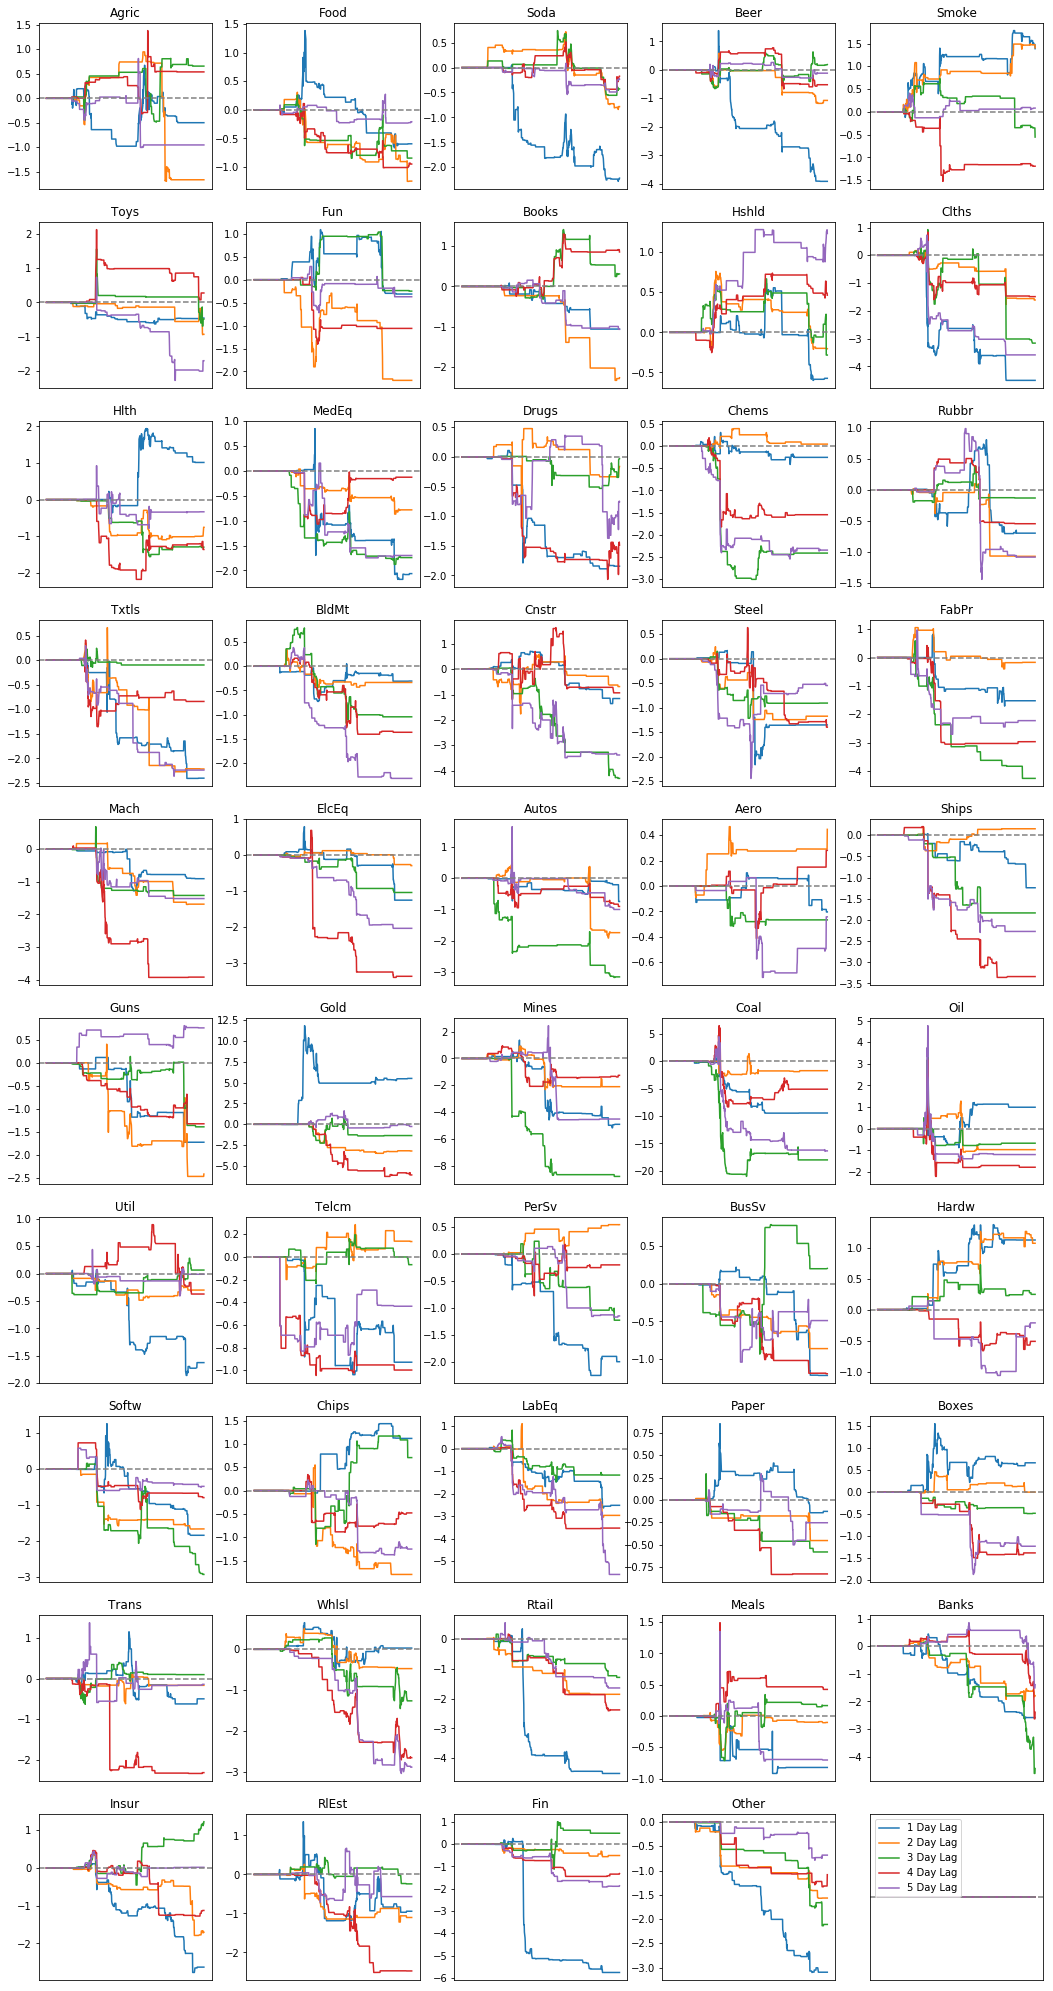

In [55]:
plotCRMSEAllLags(stockReturns, [LASSOvsHistMeancrmse1, LASSOvsHistMeancrmse2, LASSOvsHistMeancrmse3, 
                                LASSOvsHistMeancrmse4, LASSOvsHistMeancrmse5])

#### Gaussian Process Regression (1 Day Lag) vs OLS

Average R-Square OOS across all industries is 0.6781


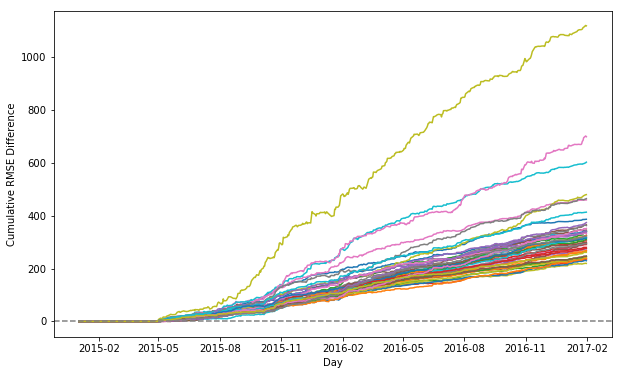

In [92]:
gprMSE1 = pd.read_csv('gprMSE1.csv', index_col = 0, header = 0).as_matrix()
GPRvsOLScrmse1, GPRvsOLSrsqr1 = compCumRMSEAndRSqr(olsMSE, gprMSE1, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsOLSrsqr1))

plotCRMSEAllInd(stockReturns, GPRvsOLScrmse1)

#### Gaussian Process Regression (2 Days Lag) vs OLS

In [254]:
gprMSE2 = pd.read_csv('gprMSE2.csv', index_col = 0, header = 0).as_matrix()
GPRvsOLScrmse2, GPRvsOLSrsqr2 = compCumRMSEAndRSqr(olsMSE, gprMSE2, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsOLSrsqr2))

# Graph looks similar so we shall not replot
#lotCRMSEAllInd(stockReturns, GPRvsOLScrmse2)

Average R-Square OOS across all industries is 0.6787


#### Gaussian Process Regression (3 Days Lag) vs OLS

In [256]:
gprMSE3 = pd.read_csv('gprMSE3.csv', index_col = 0, header = 0).as_matrix()
GPRvsOLScrmse3, GPRvsOLSrsqr3 = compCumRMSEAndRSqr(olsMSE, gprMSE3, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsOLSrsqr3))

# Graph looks similar so we shall not replot
#plotCRMSEAllInd(stockReturns, GPRvsOLScrmse3)

Average R-Square OOS across all industries is 0.6783


#### Gaussian Process Regression (4 Days Lag) vs OLS

In [257]:
gprMSE4 = pd.read_csv('gprMSE4.csv', index_col = 0, header = 0).as_matrix()
GPRvsOLScrmse4, GPRvsOLSrsqr4 = compCumRMSEAndRSqr(olsMSE, gprMSE4, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsOLSrsqr4))

# Graph looks similar so we shall not replot
#plotCRMSEAllInd(stockReturns, GPRvsOLScrmse4)

Average R-Square OOS across all industries is 0.6782


#### Gaussian Process Regression (5 Days Lag) vs OLS

In [258]:
gprMSE5 = pd.read_csv('gprMSE5.csv', index_col = 0, header = 0).as_matrix()
GPRvsOLScrmse5, GPRvsOLSrsqr5 = compCumRMSEAndRSqr(olsMSE, gprMSE5, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsOLSrsqr5))

# Graph looks similar so we shall not replot
#plotCRMSEAllInd(stockReturns, GPRvsOLScrmse5)

Average R-Square OOS across all industries is 0.6787


#### Gaussian Process Regression (All 5 Days Lag) vs OLS - Breakdown by Industry

As we can see, the GaussianProcess models of different lags have very slight difference.

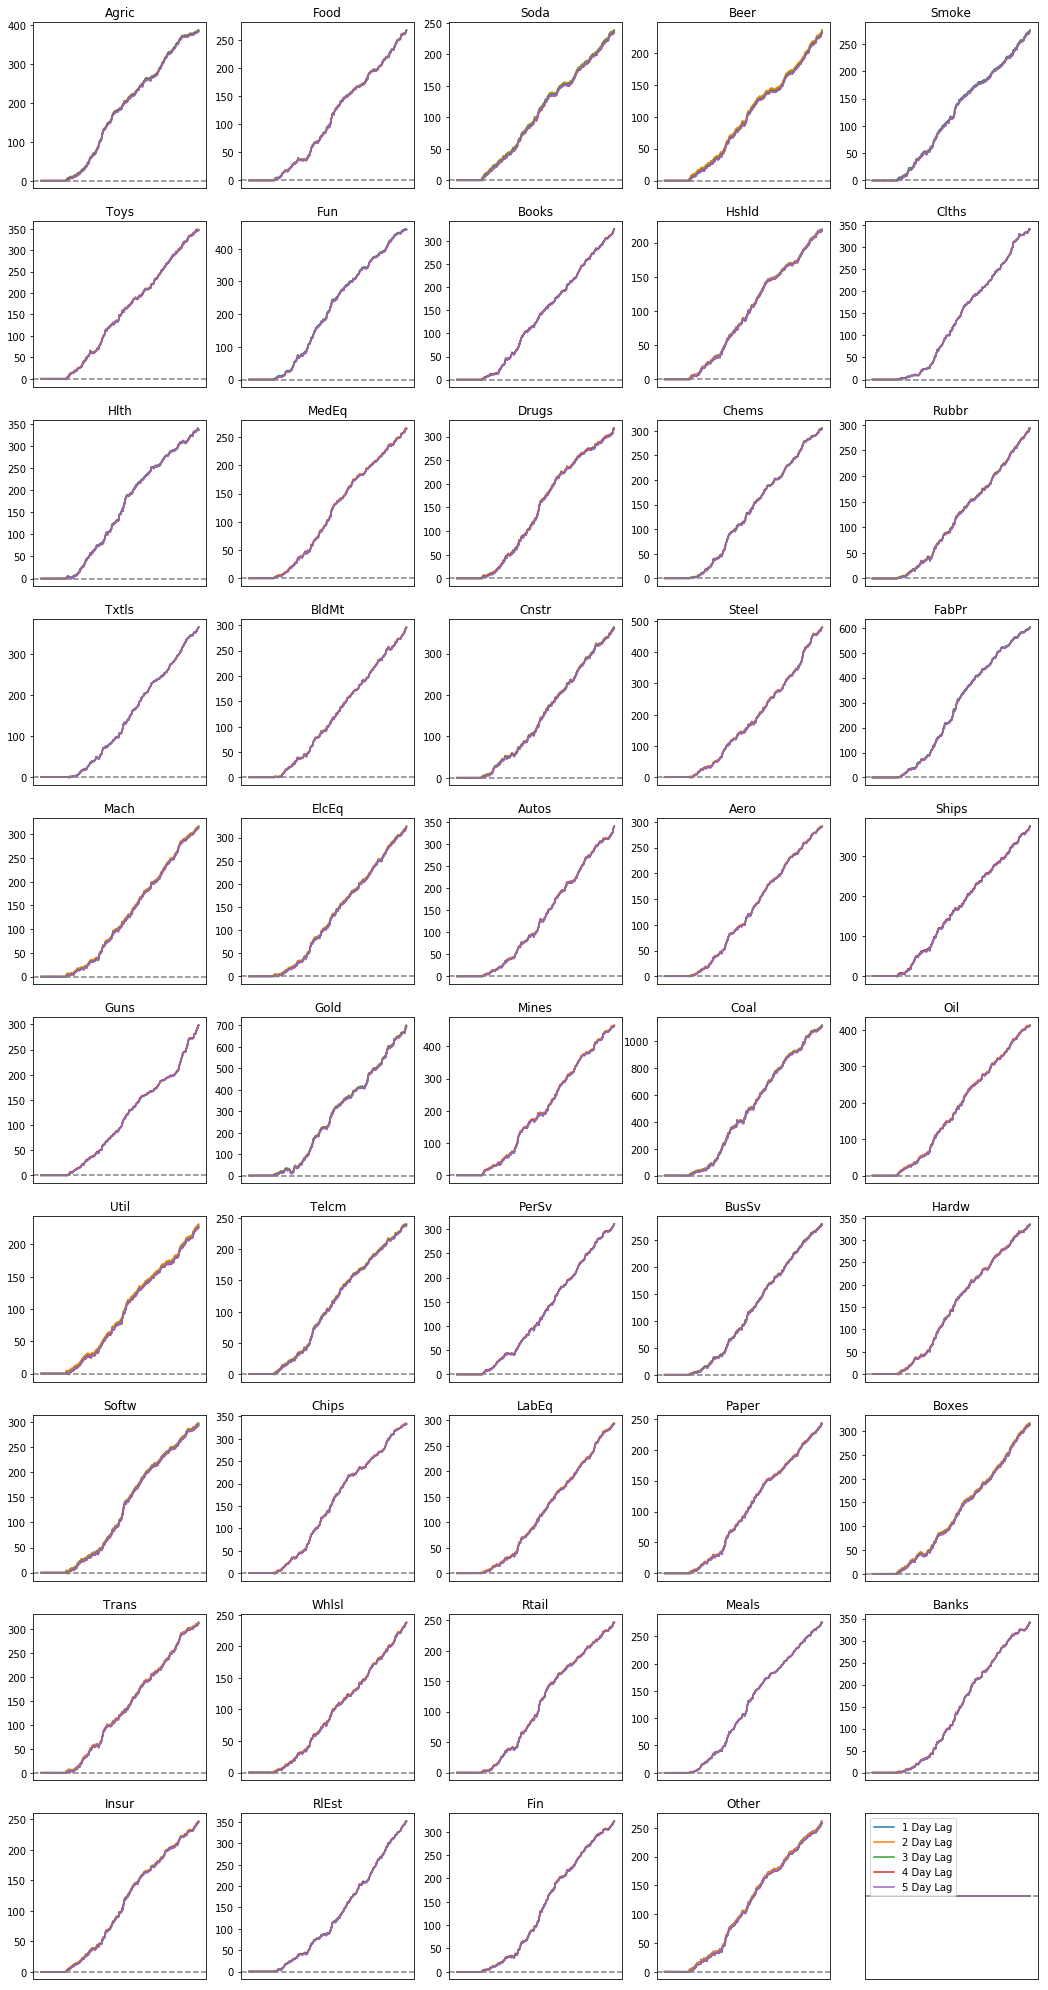

In [56]:
plotCRMSEAllLags(stockReturns, [GPRvsOLScrmse1, GPRvsOLScrmse2, GPRvsOLScrmse3, GPRvsOLScrmse4, GPRvsOLScrmse5])

#### Gaussian Process Regression (1 Day Lag) vs Historical Mean

Average R-Square OOS across all industries is 0.0137


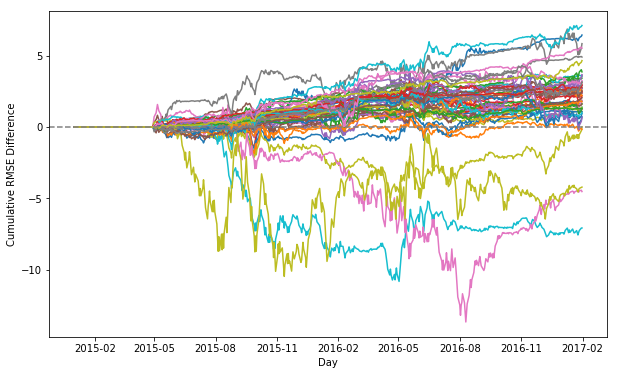

In [259]:
GPRvsHistMeancrmse1, GPRvsHistMeanrsqr1 = compCumRMSEAndRSqr(histMeanMSE, gprMSE1, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsHistMeanrsqr1))

plotCRMSEAllInd(stockReturns, GPRvsHistMeancrmse1)

#### Gaussian Process Regression (2 Days Lag) vs Historical Mean

Average R-Square OOS across all industries is 0.0135


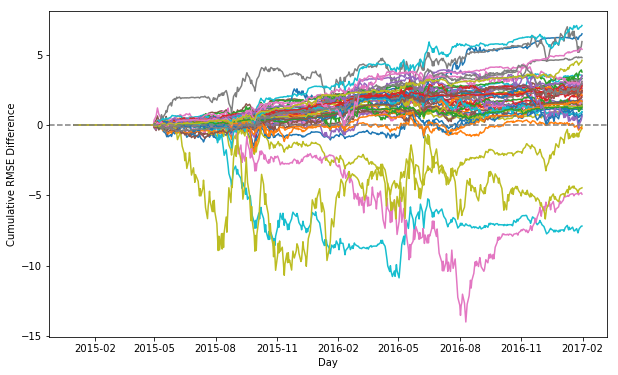

In [260]:
GPRvsHistMeancrmse2, GPRvsHistMeanrsqr2 = compCumRMSEAndRSqr(histMeanMSE, gprMSE2, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsHistMeanrsqr2))

plotCRMSEAllInd(stockReturns, GPRvsHistMeancrmse2)

#### Gaussian Process Regression (3 Days Lag) vs Historical Mean

Average R-Square OOS across all industries is 0.0138


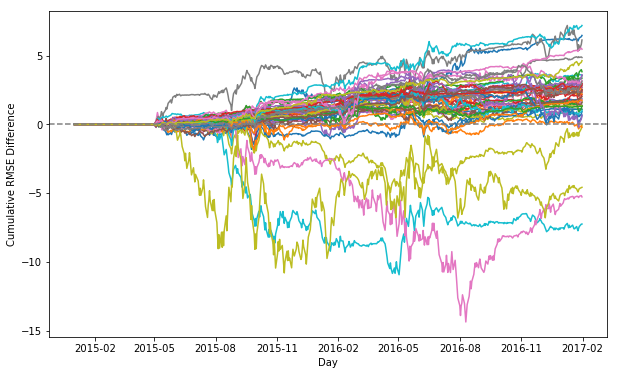

In [261]:
GPRvsHistMeancrmse3, GPRvsHistMeanrsqr3 = compCumRMSEAndRSqr(histMeanMSE, gprMSE3, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsHistMeanrsqr3))

plotCRMSEAllInd(stockReturns, GPRvsHistMeancrmse3)

#### Gaussian Process Regression (4 Days Lag) vs Historical Mean

Average R-Square OOS across all industries is 0.0138


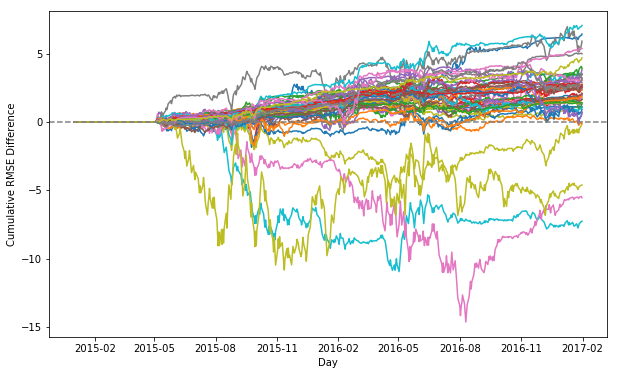

In [262]:
GPRvsHistMeancrmse4, GPRvsHistMeanrsqr4 = compCumRMSEAndRSqr(histMeanMSE, gprMSE4, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsHistMeanrsqr4))

plotCRMSEAllInd(stockReturns, GPRvsHistMeancrmse4)

#### Gaussian Process Regression (5 Days Lag) vs Historical Mean

Average R-Square OOS across all industries is 0.0136


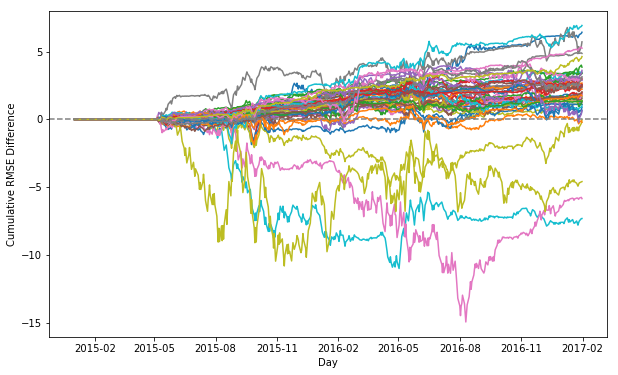

In [263]:
GPRvsHistMeancrmse5, GPRvsHistMeanrsqr5 = compCumRMSEAndRSqr(histMeanMSE, gprMSE5, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsHistMeanrsqr5))

plotCRMSEAllInd(stockReturns, GPRvsHistMeancrmse5)

#### Gaussian Process Regression (All 5 Lags) vs Historical Mean - Breakdown by Industry

We can see that for Gaussian Process regression, the difference between different lags is very minute. However, it is still economically significant (shown in the 7-page report).

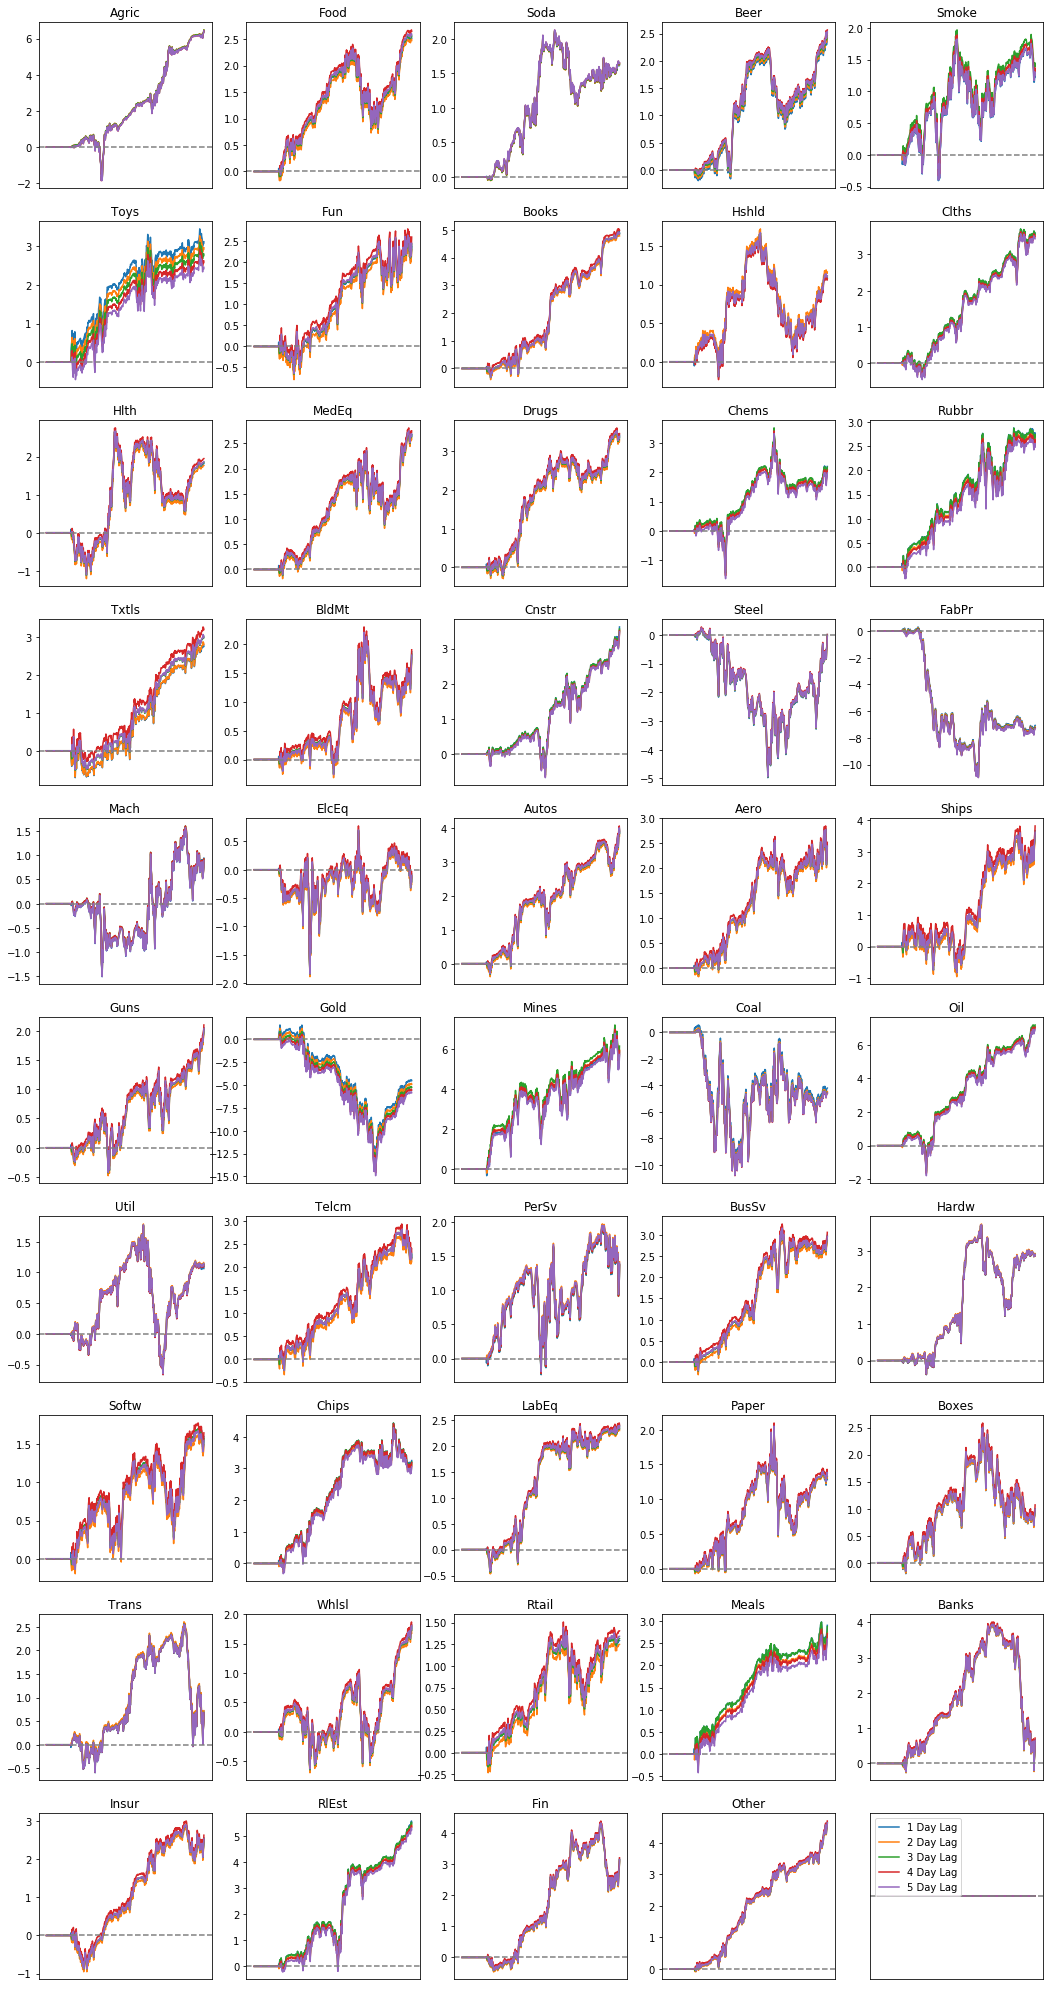

In [57]:
plotCRMSEAllLags(stockReturns, [GPRvsHistMeancrmse1, GPRvsHistMeancrmse2, GPRvsHistMeancrmse3, 
                                GPRvsHistMeancrmse4, GPRvsHistMeancrmse5])

Since all methods are able to forecast a lot better than OLS, we shall focus on the comparison with historical mean benchmarks for the rest of the models.

#### ElasticNet vs Historical Mean

The performance of Elastic Net is very close to LASSO where in many time periods, it just reverts back to historical mean prediction.

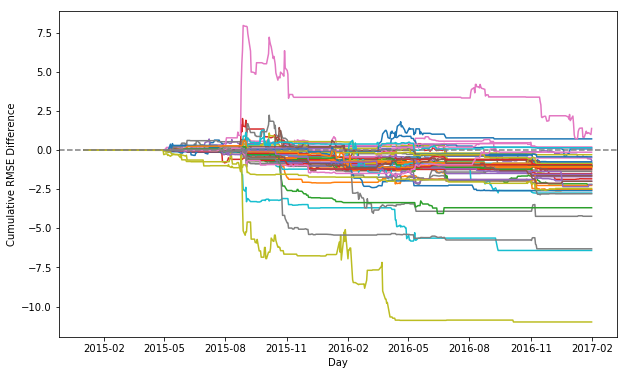

In [265]:
enMSE1 = pd.read_csv('enMSE1.csv', index_col = 0, header = 0).as_matrix()
enMSE2 = pd.read_csv('enMSE2.csv', index_col = 0, header = 0).as_matrix()
enMSE3 = pd.read_csv('enMSE3.csv', index_col = 0, header = 0).as_matrix()
enMSE4 = pd.read_csv('enMSE4.csv', index_col = 0, header = 0).as_matrix()
enMSE5 = pd.read_csv('enMSE5.csv', index_col = 0, header = 0).as_matrix()

# Compare Against OLS
ENvsOLScrmse1, ENvsOLSrsqr1 = compCumRMSEAndRSqr(olsMSE, enMSE1, stockReturns.shape[0])
ENvsOLScrmse2, ENvsOLSrsqr2 = compCumRMSEAndRSqr(olsMSE, enMSE2, stockReturns.shape[0])
ENvsOLScrmse3, ENvsOLSrsqr3 = compCumRMSEAndRSqr(olsMSE, enMSE3, stockReturns.shape[0])
ENvsOLScrmse4, ENvsOLSrsqr4 = compCumRMSEAndRSqr(olsMSE, enMSE4, stockReturns.shape[0])
ENvsOLScrmse5, ENvsOLSrsqr5 = compCumRMSEAndRSqr(olsMSE, enMSE5, stockReturns.shape[0])

# Compare Against Historical Mean
ENvsHistMeancrmse1, ENvsHistMeanrsqr1 = compCumRMSEAndRSqr(histMeanMSE, enMSE1, stockReturns.shape[0])
ENvsHistMeancrmse2, ENvsHistMeanrsqr2 = compCumRMSEAndRSqr(histMeanMSE, enMSE2, stockReturns.shape[0])
ENvsHistMeancrmse3, ENvsHistMeanrsqr3 = compCumRMSEAndRSqr(histMeanMSE, enMSE3, stockReturns.shape[0])
ENvsHistMeancrmse4, ENvsHistMeanrsqr4 = compCumRMSEAndRSqr(histMeanMSE, enMSE4, stockReturns.shape[0])
ENvsHistMeancrmse5, ENvsHistMeanrsqr5 = compCumRMSEAndRSqr(histMeanMSE, enMSE5, stockReturns.shape[0])

# Only print the cumulative RMSE difference for ElasticNet (1-Day Lag) Model vs Historical Mean
plotCRMSEAllInd(stockReturns, ENvsHistMeancrmse1)

#### Random Forest Regression vs Historical Mean

Random Forest is the worst performer.

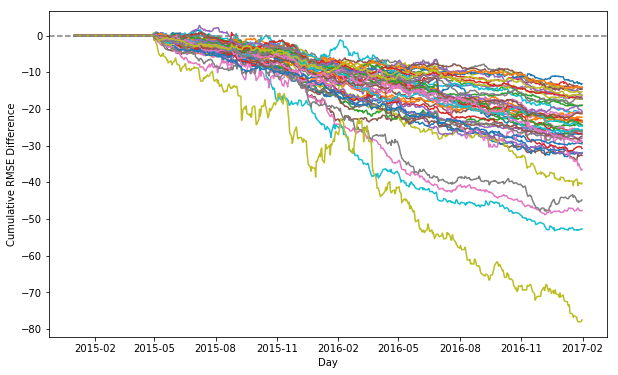

In [267]:
rfMSE1 = pd.read_csv('rfMSE1.csv', index_col = 0, header = 0).as_matrix()
rfMSE2 = pd.read_csv('rfMSE2.csv', index_col = 0, header = 0).as_matrix()
rfMSE3 = pd.read_csv('rfMSE3.csv', index_col = 0, header = 0).as_matrix()
rfMSE4 = pd.read_csv('rfMSE4.csv', index_col = 0, header = 0).as_matrix()
rfMSE5 = pd.read_csv('rfMSE5.csv', index_col = 0, header = 0).as_matrix()

# Compare Against OLS
RFvsOLScrmse1, RFvsOLSrsqr1 = compCumRMSEAndRSqr(olsMSE, rfMSE1, stockReturns.shape[0])
RFvsOLScrmse2, RFvsOLSrsqr2 = compCumRMSEAndRSqr(olsMSE, rfMSE2, stockReturns.shape[0])
RFvsOLScrmse3, RFvsOLSrsqr3 = compCumRMSEAndRSqr(olsMSE, rfMSE3, stockReturns.shape[0])
RFvsOLScrmse4, RFvsOLSrsqr4 = compCumRMSEAndRSqr(olsMSE, rfMSE4, stockReturns.shape[0])
RFvsOLScrmse5, RFvsOLSrsqr5 = compCumRMSEAndRSqr(olsMSE, rfMSE5, stockReturns.shape[0])

# Compare Against Historical Mean
RFvsHistMeancrmse1, RFvsHistMeanrsqr1 = compCumRMSEAndRSqr(histMeanMSE, rfMSE1, stockReturns.shape[0])
RFvsHistMeancrmse2, RFvsHistMeanrsqr2 = compCumRMSEAndRSqr(histMeanMSE, rfMSE2, stockReturns.shape[0])
RFvsHistMeancrmse3, RFvsHistMeanrsqr3 = compCumRMSEAndRSqr(histMeanMSE, rfMSE3, stockReturns.shape[0])
RFvsHistMeancrmse4, RFvsHistMeanrsqr4 = compCumRMSEAndRSqr(histMeanMSE, rfMSE4, stockReturns.shape[0])
RFvsHistMeancrmse5, RFvsHistMeanrsqr5 = compCumRMSEAndRSqr(histMeanMSE, rfMSE5, stockReturns.shape[0])

# Only print the cumulative RMSE difference for RandomForest (1-Day Lag) Model vs Historical Mean
plotCRMSEAllInd(stockReturns, RFvsHistMeancrmse1)

#### Support Vector Regression vs Historical Mean

For most of the industries, Support Vector Regression (SVR) does not beat historical mean benchmark.

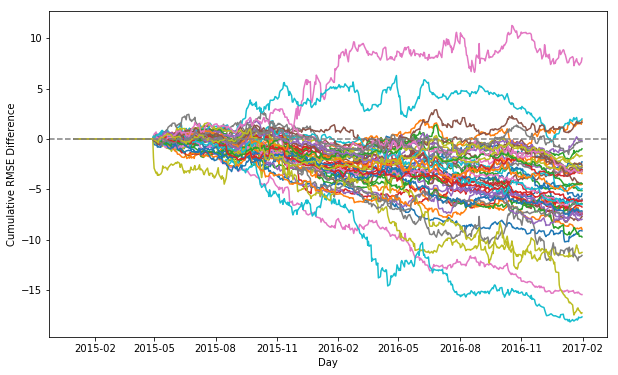

In [266]:
svrMSE1 = pd.read_csv('svrMSE1.csv', index_col = 0, header = 0).as_matrix()
svrMSE2 = pd.read_csv('svrMSE2.csv', index_col = 0, header = 0).as_matrix()
svrMSE3 = pd.read_csv('svrMSE3.csv', index_col = 0, header = 0).as_matrix()
svrMSE4 = pd.read_csv('svrMSE4.csv', index_col = 0, header = 0).as_matrix()
svrMSE5 = pd.read_csv('svrMSE5.csv', index_col = 0, header = 0).as_matrix()

# Compare Against OLS
SVRvsOLScrmse1, SVRvsOLSrsqr1 = compCumRMSEAndRSqr(olsMSE, svrMSE1, stockReturns.shape[0])
SVRvsOLScrmse2, SVRvsOLSrsqr2 = compCumRMSEAndRSqr(olsMSE, svrMSE2, stockReturns.shape[0])
SVRvsOLScrmse3, SVRvsOLSrsqr3 = compCumRMSEAndRSqr(olsMSE, svrMSE3, stockReturns.shape[0])
SVRvsOLScrmse4, SVRvsOLSrsqr4 = compCumRMSEAndRSqr(olsMSE, svrMSE4, stockReturns.shape[0])
SVRvsOLScrmse5, SVRvsOLSrsqr5 = compCumRMSEAndRSqr(olsMSE, svrMSE5, stockReturns.shape[0])

# Compare Against Historical Mean
SVRvsHistMeancrmse1, SVRvsHistMeanrsqr1 = compCumRMSEAndRSqr(histMeanMSE, svrMSE1, stockReturns.shape[0])
SVRvsHistMeancrmse2, SVRvsHistMeanrsqr2 = compCumRMSEAndRSqr(histMeanMSE, svrMSE2, stockReturns.shape[0])
SVRvsHistMeancrmse3, SVRvsHistMeanrsqr3 = compCumRMSEAndRSqr(histMeanMSE, svrMSE3, stockReturns.shape[0])
SVRvsHistMeancrmse4, SVRvsHistMeanrsqr4 = compCumRMSEAndRSqr(histMeanMSE, svrMSE4, stockReturns.shape[0])
SVRvsHistMeancrmse5, SVRvsHistMeanrsqr5 = compCumRMSEAndRSqr(histMeanMSE, svrMSE5, stockReturns.shape[0])

# Only print the cumulative RMSE difference for SVR (1-Day Lag) Model vs Historical Mean
plotCRMSEAllInd(stockReturns, SVRvsHistMeancrmse1)

### Best Set of Lags in Forecasting

#### Comparison of R-Square OOS (for all the predictive Models) vs Historical Mean Benchmark

Only Gaussian Process Regression (4-Days Lag) model outperforms historical mean benchmark (i.e. positive average R-Square OOS) while Random Forest Regression (1-Day Lag) is the worst performer.

In [271]:
RsqrMatrix = np.array([
    [np.mean(LASSOvsHistMeanrsqr1), np.mean(LASSOvsHistMeanrsqr2), np.mean(LASSOvsHistMeanrsqr3), 
     np.mean(LASSOvsHistMeanrsqr4), np.mean(LASSOvsHistMeanrsqr5)], 
    [np.mean(ENvsHistMeanrsqr1), np.mean(ENvsHistMeanrsqr2), np.mean(ENvsHistMeanrsqr3), 
     np.mean(ENvsHistMeanrsqr4), np.mean(ENvsHistMeanrsqr5)], 
    [np.mean(RFvsHistMeanrsqr1), np.mean(RFvsHistMeanrsqr2), np.mean(RFvsHistMeanrsqr3), 
     np.mean(RFvsHistMeanrsqr4), np.mean(RFvsHistMeanrsqr5)], 
    [np.mean(GPRvsHistMeanrsqr1), np.mean(GPRvsHistMeanrsqr2), np.mean(GPRvsHistMeanrsqr3), 
     np.mean(GPRvsHistMeanrsqr4), np.mean(GPRvsHistMeanrsqr5)], 
    [np.mean(SVRvsHistMeanrsqr1), np.mean(SVRvsHistMeanrsqr2), np.mean(SVRvsHistMeanrsqr3), 
     np.mean(SVRvsHistMeanrsqr4), np.mean(SVRvsHistMeanrsqr5)]])
RsqrDF = pd.DataFrame(RsqrMatrix, 
                      index = ['LASSO', 'ElasticNet', 'RandomForest', 'GaussianProces', 'SupportVector'], 
                      columns = [x for x in range(1, 6)])

# Rows = Models, Columns = Number of Day Lags
RsqrDF

1       2       3       4       5
LASSO          -0.0071 -0.0051 -0.0055 -0.0066 -0.0060
ElasticNet     -0.0090 -0.0061 -0.0063 -0.0088 -0.0084
RandomForest   -0.1071 -0.1051 -0.0918 -0.1005 -0.0986
GaussianProces  0.0137  0.0135  0.0138  0.0138  0.0136
SupportVector  -0.0210 -0.0189 -0.0128 -0.0110 -0.0114

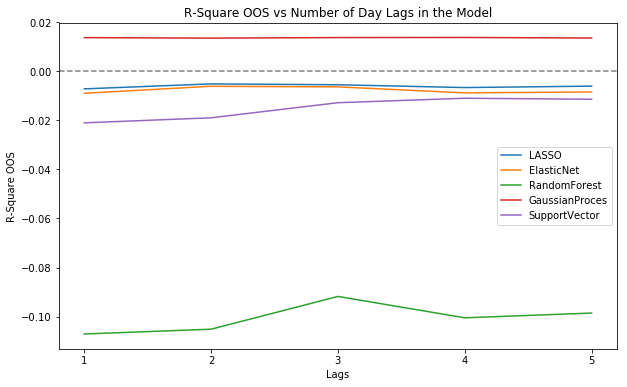

In [272]:
plt.figure(figsize = (10, 6))
for i in range(RsqrDF.shape[0]):
    plt.plot(RsqrDF.columns, RsqrDF.iloc[i, :], label = RsqrDF.index.values[i])
plt.legend()
plt.axhline(0, color = 'grey', ls = 'dashed')
plt.title("R-Square OOS vs Number of Day Lags in the Model")
plt.xticks(RsqrDF.columns)
plt.xlabel("Lags")
plt.ylabel("R-Square OOS")
plt.show()
plt.close()
    

#### Comparison of R-Square OOS (for all the predictive Models) vs OLS Benchmark

All models are able to beat OLS forecast by a large margin. Gaussian Process Regression (2-Days Lag) model performs the best while Random Forest Regression (1-Day Lag) is the worst.

In [273]:
RsqrOLSMatrix = np.array([
    [np.mean(LASSOvsOLSrsqr1), np.mean(LASSOvsOLSrsqr2), np.mean(LASSOvsOLSrsqr3), 
     np.mean(LASSOvsOLSrsqr4), np.mean(LASSOvsOLSrsqr5)], 
    [np.mean(ENvsOLSrsqr1), np.mean(ENvsOLSrsqr2), np.mean(ENvsOLSrsqr3), 
     np.mean(ENvsOLSrsqr4), np.mean(ENvsOLSrsqr5)], 
    [np.mean(RFvsOLSrsqr1), np.mean(RFvsOLSrsqr2), np.mean(RFvsOLSrsqr3), 
     np.mean(RFvsOLSrsqr4), np.mean(RFvsOLSrsqr5)], 
    [np.mean(GPRvsOLSrsqr1), np.mean(GPRvsOLSrsqr2), np.mean(GPRvsOLSrsqr3), 
     np.mean(GPRvsOLSrsqr4), np.mean(GPRvsOLSrsqr5)], 
    [np.mean(SVRvsOLSrsqr1), np.mean(SVRvsOLSrsqr2), np.mean(SVRvsOLSrsqr3), 
     np.mean(SVRvsOLSrsqr4), np.mean(SVRvsOLSrsqr5)]])
RsqrOLSDF = pd.DataFrame(RsqrOLSMatrix, 
                         index = ['LASSO', 'ElasticNet', 'RandomForest', 'GaussianProces', 'SupportVector'], 
                         columns = [x for x in range(1, 6)])

# Rows = Models, Columns = Number of Day Lags
RsqrOLSDF

1      2      3      4      5
LASSO          0.6713 0.6726 0.6720 0.6715 0.6722
ElasticNet     0.6707 0.6723 0.6717 0.6708 0.6715
RandomForest   0.6387 0.6399 0.6439 0.6409 0.6422
GaussianProces 0.6781 0.6787 0.6783 0.6782 0.6787
SupportVector  0.6668 0.6680 0.6696 0.6701 0.6705

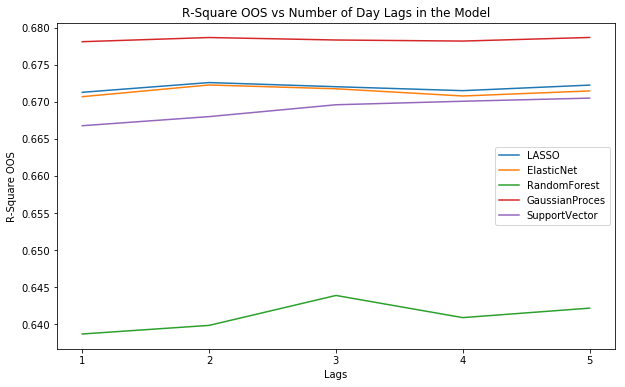

In [275]:
plt.figure(figsize = (10, 6))
for i in range(RsqrOLSDF.shape[0]):
    plt.plot(RsqrOLSDF.columns, RsqrOLSDF.iloc[i, :], label = RsqrOLSDF.index.values[i])
plt.legend()
plt.title("R-Square OOS vs Number of Day Lags in the Model")
plt.xticks(RsqrDF.columns)
plt.xlabel("Lags")
plt.ylabel("R-Square OOS")
plt.show()
plt.close()

### Lag Structure for Different Industries

This section summarises which lag results in the highest R-Square OOS for each of the industry. The bar chart illustrates the number of industries achieving highest R-Square OOS using different lags for LASSO forecasting. It can be observed that each industry has different lag structure.

In [130]:
# The Variables used in the LASSO models with different lag period
lassoVars1 = pd.read_csv('lassoVars1.csv', index_col = 0, header = 0).as_matrix()
lassoVars2 = pd.read_csv('lassoVars2.csv', index_col = 0, header = 0).as_matrix()
lassoVars3 = pd.read_csv('lassoVars3.csv', index_col = 0, header = 0).as_matrix()
lassoVars4 = pd.read_csv('lassoVars4.csv', index_col = 0, header = 0).as_matrix()
lassoVars5 = pd.read_csv('lassoVars5.csv', index_col = 0, header = 0).as_matrix()

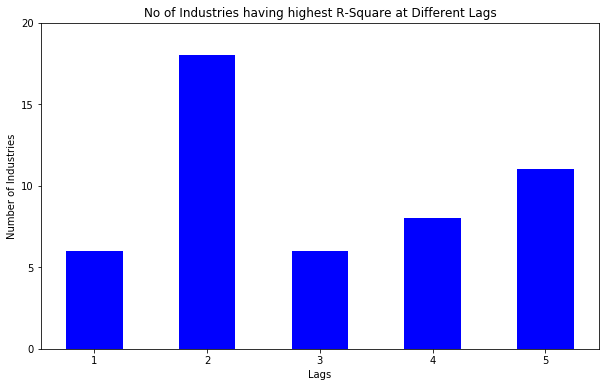

In [156]:
# Get the best lag for each industry (for each industry, which lag achieves highest R-Square?)
bestLag = np.argmax(np.vstack((LASSOvsOLSrsqr1, LASSOvsOLSrsqr2, LASSOvsOLSrsqr3, LASSOvsOLSrsqr4, LASSOvsOLSrsqr5)), 
                    axis = 0) + 1

bestLagCount = [list(bestLag).count(x) for x in (range(1, 6))]

plt.figure(figsize = (10, 6))
plt.bar(range(1, 6), bestLagCount, width = 0.5, color='b')
plt.yticks(np.arange(0, 21, 5))
plt.title("No of Industries having highest R-Square at Different Lags")
plt.xlabel("Lags")
plt.ylabel("Number of Industries")
plt.show()
plt.close()

In [284]:
print("The industries which perform best using 1 day lag:")
print(industryNames[np.where(bestLag == 1)[0]])

The industries which perform best using 1 day lag
['Fun' 'Mach' 'Gold' 'Oil' 'Trans' 'Whlsl']


In [285]:
print("The industries which perform best using all 5 days lagged returns:")
print(industryNames[np.where(bestLag == 5)[0]])

The industries which perform best using all 5 days lagged returns:
['Food' 'Hlth' 'Rubbr' 'Steel' 'FabPr' 'Autos' 'Guns' 'Paper' 'Rtail'
 'Banks' 'RlEst']


### Leader Industry

In this section, we would like to find out the most frequently used forecasters to predict the future industry returns. The below function aggregates the industry usage across different lags (for the LASSO model which uses more than 1 day lag).

In [193]:
# Aggregate All the Lags Usage of Indsutries
def aggAcrossLags(variableMatrix, numInd):
    newMatrix = variableMatrix[:, 0:numInd].copy()
    i = 1
    while (variableMatrix.shape[1] > i * noInd):
        newMatrix = newMatrix + variableMatrix[:, (i*noInd):((i+1)*noInd)]
        i += 1
    return newMatrix

#### Top 5 Forecasters Used in 1-Day LASSO

In [279]:
# Industries used in 1-day lag forecasting (number of times used in each rolling window for all industries)
# Number of times an industry was used in LASSO (1-Day lag)
forecastUsed1 = np.sum(lassoVars1, axis = 0)

#leaderInd = forecastUsed1.argsort()[-3:][::-1]

# Index of the industries (sorted by usage - most used comes first)
sortedForecast1 = forecastUsed1.argsort()[::-1]

# Get the number of times it is being used
mostUsed1 = []
for idx in sortedForecast1:
    mostUsed1.append(forecastUsed1[idx])

# Top 5 forecasters
pd.DataFrame(mostUsed1, index = industryNames[sortedForecast1], columns = ["TimesUsed"]).iloc[:5, :] 

TimesUsed
Drugs       1559
Toys        1341
Clths       1151
MedEq        974
Hlth         714

#### Top 5 Forecasters Used in 2-Days LASSO

In [280]:
# Industries used in 2-days lag forecasting (number of times used in each rolling window for all industries)

# Aggregate the usage of 2 days lagged return
lassoVars2agg = aggAcrossLags(lassoVars2, noInd)

# Number of times an industry was used in LASSO (2-Days lag)
forecastUsed2 = np.sum(lassoVars2agg, axis = 0)

#leaderInd = forecastUsed2.argsort()[-3:][::-1]

# Index of the industries (sorted by usage - most used comes first)
sortedForecast2 = forecastUsed2.argsort()[::-1]

# Get the number of times it is being used
mostUsed2 = []
for idx in sortedForecast2:
    mostUsed2.append(forecastUsed2[idx])

# Top 5 forecasters
pd.DataFrame(mostUsed2, index = industryNames[sortedForecast2], columns = ["TimesUsed"]).iloc[:5, :] 

TimesUsed
Hlth        1232
Drugs       1089
Toys         793
Gold         746
Guns         651

#### Top 5 Forecasters Used in 3-Days LASSO

In [281]:
# Industries used in 3-days lag forecasting (number of times used in each rolling window for all industries)

# Aggregate the usage of 3 days lagged return
lassoVars3agg = aggAcrossLags(lassoVars3, noInd)

# Number of times an industry was used in LASSO (3-Days lag)
forecastUsed3 = np.sum(lassoVars3agg, axis = 0)

#leaderInd = forecastUsed3.argsort()[-3:][::-1]

# Index of the industries (sorted by usage - most used comes first)
sortedForecast3 = forecastUsed3.argsort()[::-1]

# Get the number of times it is being used
mostUsed3 = []
for idx in sortedForecast3:
    mostUsed3.append(forecastUsed3[idx])

# Top 5 forecasters
pd.DataFrame(mostUsed3, index = industryNames[sortedForecast3], columns = ["TimesUsed"]).iloc[:5, :] 

TimesUsed
Hlth        1193
Drugs       1150
FabPr        954
Gold         764
Guns         724

#### Top 5 Forecasters Used in 4-Days LASSO

In [282]:
# Industries used in 4-days lag forecasting (number of times used in each rolling window for all industries)

# Aggregate the usage of 4 days lagged return
lassoVars4agg = aggAcrossLags(lassoVars4, noInd)

# Number of times an industry was used in LASSO (4-Days lag)
forecastUsed4 = np.sum(lassoVars4agg, axis = 0)

#leaderInd = forecastUsed4.argsort()[-3:][::-1]

# Index of the industries (sorted by usage - most used comes first)
sortedForecast4 = forecastUsed4.argsort()[::-1]

# Get the number of times it is being used
mostUsed4 = []
for idx in sortedForecast4:
    mostUsed4.append(forecastUsed4[idx])

# Top 5 forecasters
pd.DataFrame(mostUsed4, index = industryNames[sortedForecast4], columns = ["TimesUsed"]).iloc[:5, :] 

TimesUsed
Hlth        1331
Drugs       1154
Clths        819
FabPr        798
Toys         650

#### Top 5 Forecasters Used in 5-Days LASSO

In [283]:
# Industries used in 5-days lag forecasting (number of times used in each rolling window for all industries)

# Aggregate the usage of 5 days lagged return
lassoVars5agg = aggAcrossLags(lassoVars5, noInd)

# Number of times an industry was used in LASSO (5-Days lag)
forecastUsed5 = np.sum(lassoVars5agg, axis = 0)

#leaderInd = forecastUsed5.argsort()[-3:][::-1]

# Index of the industries (sorted by usage - most used comes first)
sortedForecast5 = forecastUsed5.argsort()[::-1]

# Get the number of times it is being used
mostUsed5 = []
for idx in sortedForecast5:
    mostUsed5.append(forecastUsed5[idx])

# Top 5 forecasters
pd.DataFrame(mostUsed5, index = industryNames[sortedForecast5], columns = ["TimesUsed"]).iloc[:5, :] 

TimesUsed
Hlth        1337
Drugs       1050
FabPr        809
Clths        764
Toys         754

### Extra

#### Calculation of Sharpe Ratio

SP500Daily.csv file contains the daily closing price of S&P 500 index (from 3-Jan-1950 to 18-Apr-2017), we will use these data to calculate the expected daily return and the associated standard deviation (for the eventual derivation of Sharpe Ratio).

In [219]:
SP500Daily = pd.read_csv('SP500Daily.csv', index_col = 0)

In [220]:
# Reverse the dataframe so that earliest record is at the top
SP500Daily = SP500Daily.iloc[::-1]

# Expressed in Percentage Change in Price
SP500Daily = SP500Daily.pct_change() * 100

In [227]:
# Expected Daily Return
expDaily = SP500Daily['Adj Close'].mean(skipna = True)
# Standard Deviation of Daily Return
sdDaily = SP500Daily['Adj Close'].std(skipna = True)

# Current annual rate of the three-month US treasury bond is 0.82%
# NYSE has on average 252 trading days
# Converted the compound daily rate will be:
annualRf = 0.82
dailyRf = ((1 + annualRf/100) ** (1/252) - 1) * 100

sharpeSP500 = (expDaily - dailyRf) / sdDaily
print("Daily Sharpe Ratio of S&P 500 is: %.4f" % sharpeSP500)

Daily Sharpe Ratio of S&P 500 is: 0.0318


#### Does Feature Selection (PCA) Improve the Forecasting?

We know that our best-performing model is the Gaussian Process Regression (with 4-days lags). The performance is displayed again below:

Average R-Square OOS across all industries is 0.0138


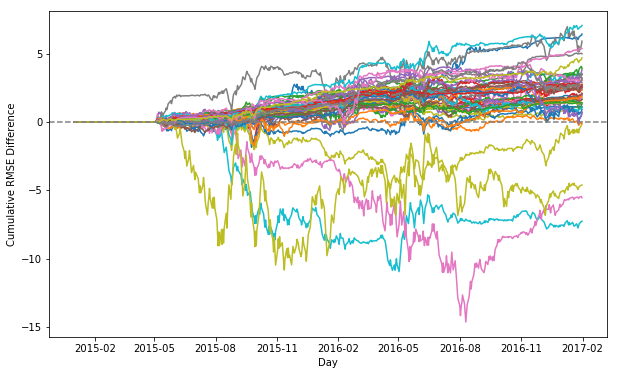

In [286]:
GPRvsHistMeancrmse4, GPRvsHistMeanrsqr4 = compCumRMSEAndRSqr(histMeanMSE, gprMSE4, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GPRvsHistMeanrsqr4))

plotCRMSEAllInd(stockReturns, GPRvsHistMeancrmse4)

In many cases, prior feature selection does improve the performance of supervised learning. We would test below whether feature selection by Principal Component Analysis (PCA) helps to improve our best model.

In [288]:
# Chain PCA with Gaussian Process Regression
gpr = gaussian_process.GaussianProcessRegressor()
pca = decomposition.PCA()
pipe = pipeline.Pipeline(steps = [('pca', pca), ('gpr', gpr)])
pcaGprMSE4 = fitAndPredictOOS(stockReturns, 
                              model = RandomizedSearchCV(pipe, 
                                                         dict(pca__n_components = stats.randint(20, 30), 
                                                              gpr__alpha = stats.uniform(loc = 1e-10, scale = 1e-1)), 
                                                         n_iter = 10, 
                                                         cv = TimeSeriesSplit(n_splits = 10)), 
                              windowSize = w, lag = 4)

Average R-Square OOS across all industries is 0.0138


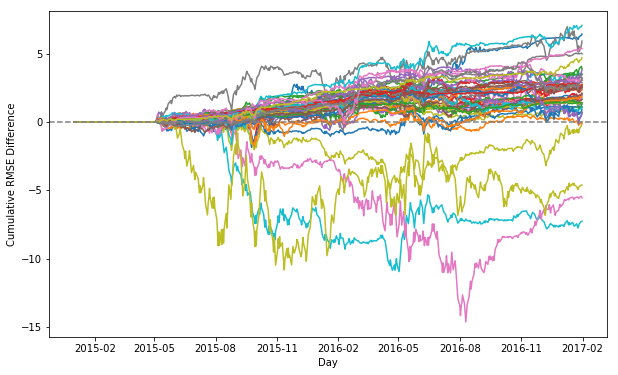

In [289]:
# Plot the Performance
pcaGprvsHistMeancrmse4, pcaGprvsHistMeanrsqr4 = compCumRMSEAndRSqr(histMeanMSE, pcaGprMSE4, stockReturns.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(pcaGprvsHistMeanrsqr4))

plotCRMSEAllInd(stockReturns, pcaGprvsHistMeancrmse4)

As we can see above, the performance is almost identical to Gaussian Process Regression without prior feature selection. In this case, it seems that huge amount of predictors do not impact the performance of GP regression.

#### Can Commodities Industry (e.g. Gold Industry) Returns be Predicted Using the Returns of Gold & Silver Commodities?

As mentioned in the 7-page report, industry involved in commodities business is traditionally viewed by investors as a proxy to invest in safe haven commodities like gold. It is expected that these industry returns cannot be well forecasted using the lagged returns of equity market.

In this section, we would explore if the their returns can be better forecasted using the return of Gold & Silver commodities. The daily returns of Gold & Silver commodities have been included as two additional columns in the Excel file 'Data-GoldSilver.xlsx'.

In [299]:
# Read in Data
stockReturns2 = pd.read_excel('Data-GoldSilver.xlsx', skiprows = 4, parse_cols = 'B:BA', index_col = 0)
stockReturns2.columns = [x.strip() for x in stockReturns2.columns]

In [304]:
param_dist = {"alpha": stats.uniform(loc = 1e-10, scale = 1e-1)}
GoldgprMSE4 = fitAndPredictOOS(stockReturns2, 
                               model = RandomizedSearchCV(gaussian_process.GaussianProcessRegressor(), 
                                                          param_distributions = param_dist, 
                                                          n_iter = 10, 
                                                          cv = TimeSeriesSplit(n_splits = 10)), 
                               windowSize = w, lag = 4)

Average R-Square OOS across all industries is 0.0138


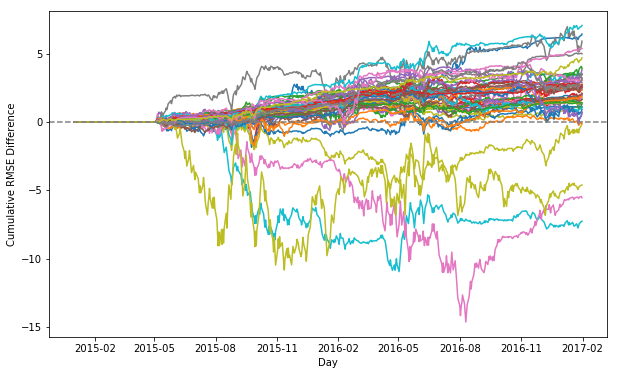

In [306]:
GoldgprvsHistMeancrmse4, GoldgprvsHistMeanrsqr4 = compCumRMSEAndRSqr(histMeanMSE, GoldgprMSE4[:, :noInd], stockReturns2.shape[0])
print("Average R-Square OOS across all industries is %.4f" % np.mean(GoldgprvsHistMeanrsqr4))

plotCRMSEAllInd(stockReturns, GoldgprvsHistMeancrmse4)

Again, this performance is almost identical to the earlier Gaussian Process Regression. So we conclude that the past Gold and Silver commodities returns do not improve the forecasting of industry returns. In other words, daily returns of Gold and Silver commodities do not have meaningful predictive relationships with the future stock returns of industries involved in commodities business (e.g. Gold industry).